# Example: quadratic line fitting (1)

A first simple example of how to use the calibration code.

In [2]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle as pk
import subprocess
import shlex
import tempfile

In [3]:
# special imports
from utils import *

In [4]:
# pyplot settings
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["axes.titleweight"] = "bold"

## 1. Setup

In [5]:
# the model to fit
def f(x, a=-2, b=0, c=2):
    return a*(x - b)**2 + c

In [6]:
# lower and upper bounds for the parameters
a_low = -3; a_upp = -1
b_low = -0.1; b_upp = 0.1
c_low = 1; c_upp = 3

In [7]:
# generate a data set
xdata = np.arange(start=0, stop=2.5, step=0.5)
ydata = np.array([f(x) for x in xdata])
sdata = np.array([1/2 - f(x)/6 for x in xdata])

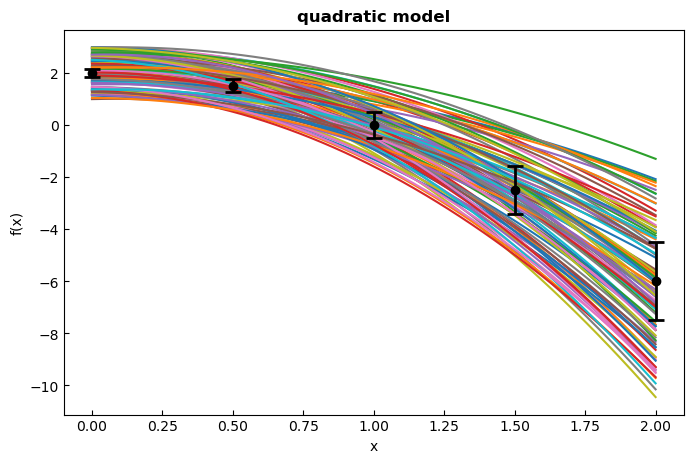

In [8]:
# plot model evaluations and data
x = np.linspace(0, 2)
n = 100
_, ax = plt.subplots(figsize=(8, 5))
for _ in range(n):
    a = (a_upp - a_low)*np.random.rand() + a_low
    b = (b_upp - b_low)*np.random.rand() + b_low
    c = (c_upp - c_low)*np.random.rand() + c_low
    ax.plot(x, f(x, a=a, b=b, c=c))
ax.errorbar(xdata, ydata, yerr=sdata, color="black", linewidth=0, elinewidth=2, capsize=6, marker="o", capthick=2, zorder=100)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("quadratic model")
if save:
    plt.savefig(os.path.join(save_location, "example_1_quadratic.png"))
plt.show()

## 2. Surrogate construction

In [9]:
# generate data
n = 100
xs = []
ys = []
for _ in range(n):
    a = (a_upp - a_low)*np.random.rand() + a_low
    b = (b_upp - b_low)*np.random.rand() + b_low
    c = (c_upp - c_low)*np.random.rand() + c_low
    xs.append([a, b, c])
    ys.append(f(xdata, a=a, b=b, c=c))
xs = np.vstack(xs)
ys = np.vstack(ys)

In [10]:
# construct surrogate models
with tempfile.TemporaryDirectory() as tmp:

    # save input and output data
    np.savetxt(os.path.join(tmp, "ptrain.dat"), xs)
    np.savetxt(os.path.join(tmp, "qtrain.dat"), xs)
    np.savetxt(os.path.join(tmp, "ytrain.dat"), ys)

    # save parameter ranges
    np.savetxt(os.path.join(tmp, "param_ranges.dat"), np.array([[a_low, a_upp], [b_low, b_upp], [c_low, c_upp]]))

    # run wibcs
    subprocess.run(shlex.split(f"{path_to_python} {path_to_uq_pc} -r offline_post -p param_ranges.dat -m lsq -n {xs.shape[0]} -s rand -t 2 -z"), cwd=tmp, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    # load results
    with open(os.path.join(tmp, "results.pk"), "rb") as file:
        results = pk.load(file)

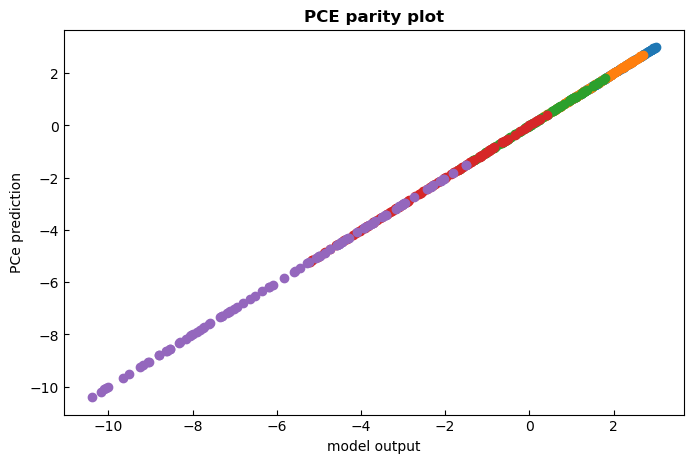

In [11]:
# plot PCE accuracy
_, ax = plt.subplots(figsize=(8, 5))
for i in range(len(results)):
    ytrain = results["training"][2][:, i]
    ytrain_pce = results["training"][3][:, i]
    ax.scatter(ytrain, ytrain_pce)
ax.set_xlabel("model output")
ax.set_ylabel("PCe prediction")
ax.set_title("PCE parity plot")
if save:
    plt.savefig(os.path.join(save_location, "example_1_parity.png"))
plt.show()

## 3. Calibration

In [12]:
# perform calibration
with tempfile.TemporaryDirectory() as tmp:

    # save data mean and error bars
    np.savetxt(os.path.join(tmp, "data.dat"), np.vstack([ydata, sdata]).T)

    # save PCE coefficients and multi-indices
    for j in range(len(results)):
        np.savetxt(os.path.join(tmp, f"pccf.{j + 1}.dat"), results["pcmi"][0][j])
        np.savetxt(os.path.join(tmp, f"mindex.{j + 1}.dat"), results["pcmi"][1][j], fmt="%d")

    # save prior
    with open(os.path.join(tmp, "prior.dat"), "w") as f:
        f.write(f"gaussian {(a_low + a_upp)/2} {(a_upp - a_low)/2}\n")
        f.write(f"gaussian {(b_low + b_upp)/2} {(b_upp - b_low)/2}\n")
        f.write(f"gaussian {(c_low + c_upp)/2} {(c_upp - c_low)/2}\n")
    
    # run calibration
    subprocess.run(shlex.split(path_to_dfi + " -d data.dat -c pccf.{n}.dat -i mindex.{n}.dat -v pccf.{n}.dat -w mindex.{n}.dat -g 0.1 -k 100 -m 0"), cwd=tmp)
    
    # load output files
    chain = np.loadtxt(os.path.join(tmp, "chain.dat"))
    pushforward = []
    n = 1
    pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
    while os.path.isfile(pushforward_file):
        pushforward.append(np.loadtxt(pushforward_file))
        n += 1
        pushforward_file = os.path.join(tmp, f"pushforward.1.{n}.dat")
    synthetic_data = np.loadtxt(os.path.join(tmp, "synthetic.data.1.dat"))

╭────────────────────────────────────────────────────╮
│                        dfi                         │
╰────────────────────────────────────────────────────╯
Found prior:
  => p1   : mu = -2        , sigma = 1         
  => p2   : mu = 0         , sigma = 0.1       
  => p3   : mu = 2         , sigma = 1         
Found 1 data set:
  => Data set number 1/1:
       -> y1   = 2         s1   = 0.166667  
       -> y2   = 1.5       s2   = 0.25      
       -> y3   = 0         s3   = 0.5       
       -> y4   = -2.5      s4   = 0.916667  
       -> y5   = -6        s5   = 1.5       
Reading 5 PCE models for data set number 1/1...
  => PCE number 1:
       -> PCE coefficients read from file pccf.1.dat (10 coefficients)
       -> Multi-indices read from file mindex.1.dat (10 x 3)
  => PCE number 2:
       -> PCE coefficients read from file pccf.2.dat (10 coefficients)
       -> Multi-indices read from file mindex.2.dat (10 x 3)
  => PCE number 3:
       -> PCE coefficients read from fil

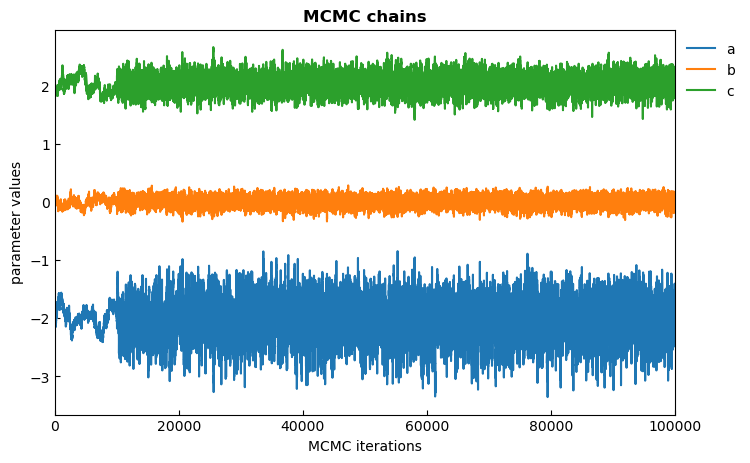

In [13]:
# plot MCMC chains
_, ax = plt.subplots(figsize=(8, 5))
for j, label in enumerate(["a", "b", "c"]):
    ax.plot(chain[:, j + 1], label=label)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), frameon=False)
ax.set_xlabel("MCMC iterations")
ax.set_ylabel("parameter values")
ax.set_title("MCMC chains")
ax.set_xlim(0, chain.shape[0])
if save:
    plt.savefig(os.path.join(save_location, "example_1_mcmc_chain.png"))
plt.show()

In [14]:
# get the MAP prediction
stacked_pushforward = np.vstack(pushforward).T
map_idx = np.argmax(chain[:, -1])
map_prediction = stacked_pushforward[map_idx, :]

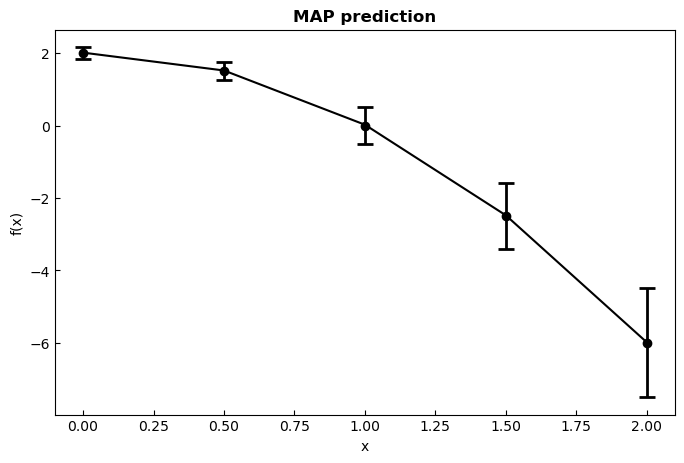

In [15]:
# plot MAP prediction
_, ax = plt.subplots(figsize=(8, 5))
ax.plot(xdata, map_prediction, color="black")
ax.errorbar(xdata, ydata, yerr=sdata, color="black", linewidth=0, elinewidth=2, capsize=6, marker="o", capthick=2, zorder=100)
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("MAP prediction")
if save:
    plt.savefig(os.path.join(save_location, "example_1_map_prediction.png"))
plt.show()

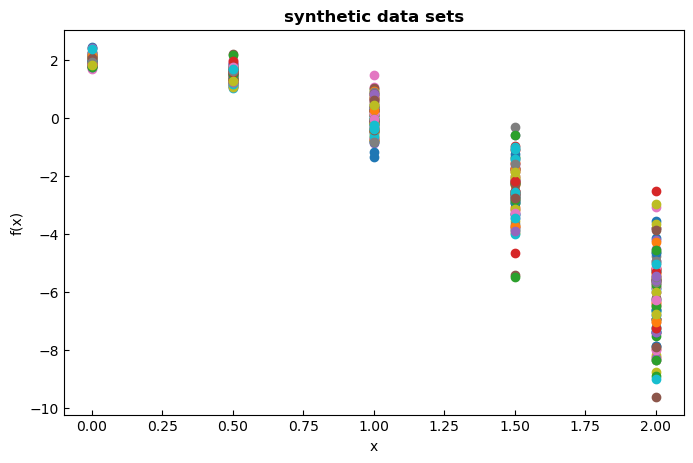

In [16]:
# plot sythetic data sets
_, ax = plt.subplots(figsize=(8, 5))
for i in range(synthetic_data.shape[1]):
    ax.scatter(xdata, synthetic_data[:, i])
ax.set_xlabel("x")
ax.set_ylabel("f(x)")
ax.set_title("synthetic data sets")
if save:
    plt.savefig(os.path.join(save_location, "example_1_synthetic_data.png"))
plt.show()